<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

This notebook demonstrates **Transfer Learning** of pre-trained models.  

We will make use of the pre-trained **AlexNet** and **VGG16** models available from the [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html#) module.  
We will train them on the [ants_and_bees](https://github.com/jaddoescad/ants_and_bees) custom dataset.

### Reference

[ginomempin / machine-learning-tutorials / docs / TransferLearning.md](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/TransferLearning.md)

### Note

This notebook requires the use of GPU (or not if you want slow/long training times).  

When running in Google Colab:
1. Select "Runtime" from the menu
1. Select "GPU" as the hardware accelerator type.

In [1]:
!pip3 install torch torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn 
from torchvision import datasets
from torchvision import models      # Contains the AlexNet and VGG16 models
from torchvision import transforms  # Contains common image pre-processing functions

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [5]:
!ls

ants_and_bees  sample_data


In [6]:
!ls ants_and_bees

train  val


In [7]:
!ls ants_and_bees/train/

ants  bees


In [0]:
!ls ants_and_bees/train/ants

In [0]:
!ls ants_and_bees/train/bees

# Setup the Training Set

## Define the Image Transformation

In [0]:
transform_training = transforms.Compose([
    # Since we are using pre-trained models, we must ensure we resize to the
    # same input dimensions used by those models during training. For AlexNet
    # and VGG16, they were trained on the ImageNet dataset, which used 224x224
    # input images.
    transforms.Resize((224, 224)),

    # Here we use Data Augmentation.
    #
    # It is a technique for expanding the training data by applying different
    # augmentations to the images, such as rotation, changing colors, zooming
    # in and out, translations, etc. This reduces overfitting, as it prevents 
    # the model from memorizing specific features of an object as it "sees" it 
    # in an image, but instead generalizes it for different appearances of the
    # same feature.
    #
    # For example, a STOP sign. The model should be able to know it's a STOP
    # sign, whether the sign is upright, rotated 90 degrees, black and white,
    # slightly skewed, shifted to the right.
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify only 3 channels since
    # the dataset provides colored images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Define the Dataset

In [11]:
# The datasets.ImageFolder API arranges the images based on the folders and 
# pre-labels them based on the folder they are in. Under "ants_and_bees/train" 
# are 2 folders: ants, bees. The API auto assigns the ants folder to be the 
# folder 0, making all ants be class 0 (or have label of 0). Similarly, the 
# bees folder is auto assigned to be folder 1, and bees become class 1.
training_dataset = datasets.ImageFolder(
    "ants_and_bees/train", 
    transform=transform_training)
training_dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ants_and_bees/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0, 2], contrast=[0, 2], saturation=[0, 2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
print(len(training_dataset))

244


In [13]:
# Provides a way to load the input data into the model in batches.
training_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=20,
    shuffle=True            # Prevent getting stuck into local/false minimums
                            # Make sure that each epoch uses a different batch
)
training_loader

## Plot the Dataset

In [0]:
# To plot, we need to convert the Tensor back to Numpy array.
def img_convert(tensor: torch.Tensor):
    image = tensor.cpu().clone().detach().numpy()

    # Convert from 3x224x224 shape to 224x224x3
    # print(image.shape)
    image = image.transpose(1, 2, 0)

    # De-normalize (reverse the normalization process earlier)
    # Convert it from [-1, 1] back to the original [0, 1]
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    # print(image.shape)
    return image

In [0]:
classes = ("ant", "bee")

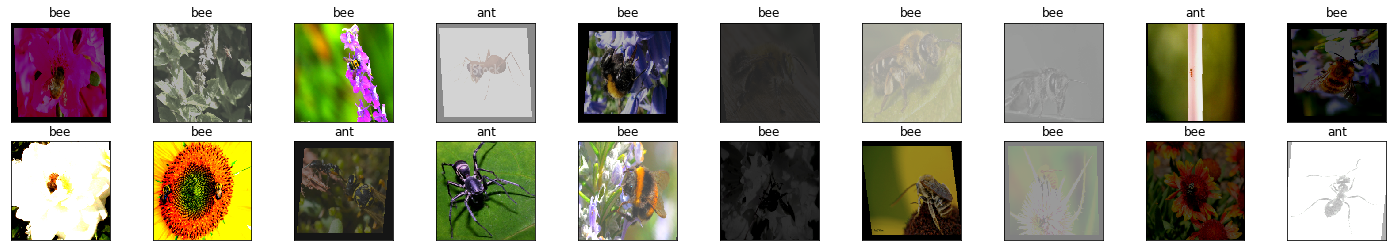

In [16]:
# Create an iterable object
# We can then use `next()` to iteratively get the next batch of data
training_dataset_iter = iter(training_loader)

images, labels = training_dataset_iter.next()
fig = plt.figure(
    figsize=(25, 4),
)

for idx in np.arange(20):
    # Make 2 rows of 10 columns
    # Note that idx is 0-based, but need to be 1-20
    axis = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  

    # Show the i-th image (using the Tensor -> Numpy conversion)
    img = img_convert(images[idx])
    plt.imshow(img)

    # Show the labels for each i-th image
    axis.set_title( classes[labels[idx].item()] )

# Setup the Validation Set

In [17]:
!ls

ants_and_bees  sample_data


In [18]:
!ls ants_and_bees/val

ants  bees


In [0]:
!ls ants_and_bees/val/ants

In [0]:
!ls ants_and_bees/val/bees

## Define the Image Transformation

In [0]:
transform_validation = transforms.Compose([
    # Since we are using pre-trained models, we must ensure we resize to the
    # same input dimensions used by those models during training. For AlexNet
    # and VGG16, they were trained on the ImageNet dataset, which used 224x224
    # input images.
    transforms.Resize((224,  224)),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify 3 channels since the
    # the dataset uses colored images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Define the Dataset

In [22]:
validation_dataset = datasets.ImageFolder(
    "ants_and_bees/val",
    transform=transform_validation 
)
validation_dataset

Dataset ImageFolder
    Number of datapoints: 153
    Root location: ants_and_bees/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [23]:
print(len(validation_dataset))

153


In [24]:
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=20,
    shuffle=False
)
validation_loader

# AlexNet

## Setup the Network

In [0]:
model = models.alexnet(pretrained=True)

In [26]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Modify the Model

### Freeze the Feature Extraction

In [0]:
# Prevent tampering with the pre-trained parameters of the Feature Extraction
# layer (the "features" layer as shown when printing the model). We do this by 
# setting that all the params in those layers be unaffected by gradient descent.
for param in model.features.parameters():
    param.requires_grad = False

### Replace the Output Layer

In [0]:
# The output layer of the pre-trained model has 1000 classes.
# For our ants and bees dataset, we only need 2.
# Therefore we need to create a new output layer to replace the existing one.
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

In [29]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Setup the Loss Function and Optimizer

In [0]:
# Use Cross Entropy Loss for multi-class datasets (instead of BCE for binary data)
criterion = nn.CrossEntropyLoss()  

# Use Gradient Descent to optimize the model.
# Specifically, the Adam optimizer (Adaptive Method Algorithms).
# The Adam optimizer is a combination of 2 extensions of SGD (Stochastic Gradient Descent):
#   Adagrad
#   RMSprop
# What distinguishes it from the SGD is that we had to be careful in choosing the proper
# the learning rate. Too small leads to very slow convergence towards minimum error/loss, 
# while too large can hinder the convergence. When using Adam optimization, it computes 
# the adaptive learning rates for EACH parameter. In practice, Adam is recommended as the
# default optimization algorithm.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001   # Too high = can lead to lower accuracy
                # Too small = can lead to slower training (i.e. too many epochs to approach 100% accuracy)
)

## Training + Validation

In [31]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
epochs = 10

training_loss_history = []
training_acc_history = []

validation_loss_history = []
validation_acc_history = []

for e in range(epochs):

    # For each epoch, iterate over all the batches to be provided
    # by the training_loader, and keep track of the *total* loss
    # for all batches.
    training_running_loss = 0.0
    training_running_acc = 0.0
    validation_running_loss = 0.0
    validation_running_acc = 0.0

    print("Epoch: {}".format(e + 1))

    # Training Loop
    for images, labels in training_loader:
        inputs = images.to(device)
        labels = labels.to(device)

        # Feedforward through the model
        outputs = model.forward(inputs)

        # Get the current loss
        loss = criterion(outputs, labels)
        training_running_loss += loss.item()

        # Backpropagate the loss to update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the current maximum scored class for each output
        # Returns a tuple
        #   0: The image scores for each of the classes
        #   1: The index of the top score (i.e. which class does each image belong to?)
        _, preds = torch.max(outputs, 1)
        training_running_acc += torch.sum(preds == labels.data)    
            # Example:
            #   If preds  = [2 3 4 5 6]
            #      labels = [2 5 4 5 6]
            #   So only the 2nd prediction is incorrect.
            #   So preds == labels will be [1 0 1 1 1].
    else:  
        epoch_training_loss = training_running_loss / len(training_loader.dataset)
        epoch_training_acc  = training_running_acc.float() / len(training_loader.dataset)

        training_loss_history.append(epoch_training_loss)
        training_acc_history.append(epoch_training_acc)

        print("Training Loss:{:.4f}, Acc:{:.4f}".format(epoch_training_loss, epoch_training_acc))

    # Validation Loop
    with torch.no_grad():
        for images, labels in validation_loader:
            inputs = images.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs) 
            
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            validation_running_acc += torch.sum(preds == labels.data)
        else:  
            epoch_validation_loss = validation_running_loss / len(validation_loader.dataset)
            epoch_validation_acc  = validation_running_acc.float() / len(validation_loader.dataset)                     

            validation_loss_history.append(epoch_validation_loss)
            validation_acc_history.append(epoch_validation_acc)

            print("Validation Loss:{:.4f}, Acc:{:.4f}".format(epoch_validation_loss, epoch_validation_acc))            

Epoch: 1
Training Loss:0.0311, Acc:0.6557
Validation Loss:0.0241, Acc:0.7908
Epoch: 2
Training Loss:0.0249, Acc:0.7336
Validation Loss:0.0173, Acc:0.8562
Epoch: 3
Training Loss:0.0230, Acc:0.7992
Validation Loss:0.0205, Acc:0.8758
Epoch: 4
Training Loss:0.0244, Acc:0.7582
Validation Loss:0.0170, Acc:0.8693
Epoch: 5
Training Loss:0.0219, Acc:0.8074
Validation Loss:0.0170, Acc:0.9020
Epoch: 6
Training Loss:0.0202, Acc:0.8197
Validation Loss:0.0170, Acc:0.9150
Epoch: 7
Training Loss:0.0179, Acc:0.8361
Validation Loss:0.0167, Acc:0.9020
Epoch: 8
Training Loss:0.0197, Acc:0.8115
Validation Loss:0.0143, Acc:0.9150
Epoch: 9
Training Loss:0.0172, Acc:0.8320
Validation Loss:0.0194, Acc:0.8758
Epoch: 10
Training Loss:0.0174, Acc:0.8607
Validation Loss:0.0179, Acc:0.9085


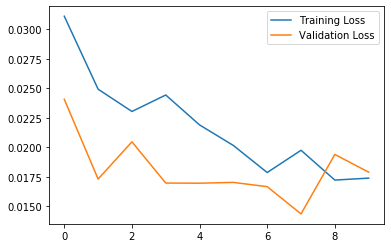

In [33]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()

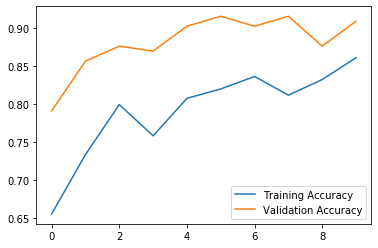

In [34]:
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(validation_acc_history, label="Validation Accuracy")
plt.legend()

## Testing

### Get a Test Image

In [0]:
from PIL import Image, ImageOps
import requests

test_ant_url = "https://i.kinja-img.com/gawker-media/image/upload/c_fill,f_auto,fl_progressive,g_center,h_675,pg_1,q_80,w_1200/tk07remacvnuvxmyhllq.jpg"
test_bee_url = "https://sureguardpest.com/wp-content/uploads/2019/06/bee-146810332.jpg"

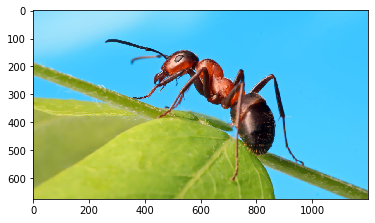

In [36]:
resp = requests.get(test_ant_url, stream=True)
img_ant = Image.open(resp.raw)
plt.imshow(img_ant)

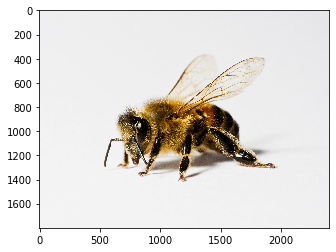

In [37]:
resp = requests.get(test_bee_url, stream=True)
img_bee = Image.open(resp.raw)
plt.imshow(img_bee)

### Do image preprocessing

The test image must match the image format on which our model was trained on.  
* 224x224
* RGB color images

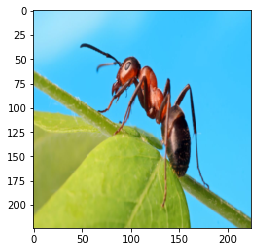

In [38]:
img_ant_trans = transform_validation(img_ant)
plt.imshow(img_convert(img_ant_trans))

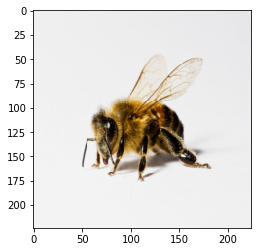

In [39]:
img_bee_trans = transform_validation(img_bee)
plt.imshow(img_convert(img_bee_trans))

### Feed to Model

In [40]:
image_ant_in = img_ant_trans.to(device).unsqueeze(0)
print(image_ant_in.size())

torch.Size([1, 3, 224, 224])


In [41]:
image_bee_in = img_bee_trans.to(device).unsqueeze(0)
print(image_bee_in.size())

torch.Size([1, 3, 224, 224])


In [42]:
output = model.forward(image_ant_in)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


In [43]:
output = model.forward(image_bee_in)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


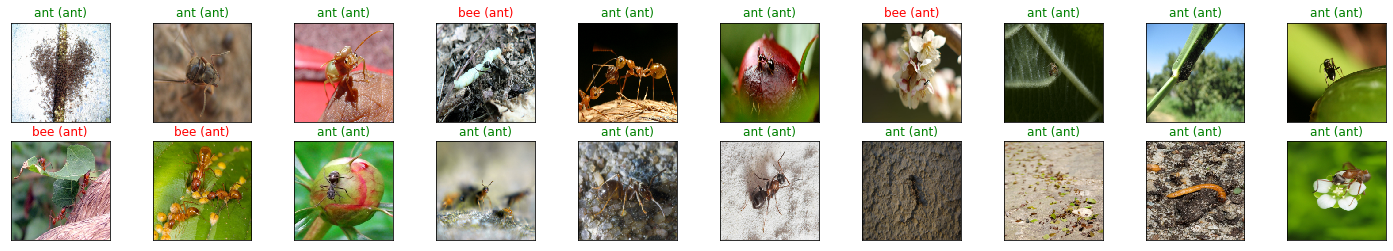

In [44]:
testdata_iter = iter(validation_loader)
images, labels = testdata_iter.next()
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title(
      "{} ({})".format(
        str(classes[preds[idx].item()]), 
        str(classes[labels[idx].item()])), 
      color=("green" if preds[idx]==labels[idx] else "red"))

# VGG16

## Setup the Network

In [0]:
model = models.vgg16(pretrained=True)

In [66]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Modify the Model

### Freeze the Feature Extraction

In [0]:
# Prevent tampering with the pre-trained parameters of the Feature Extraction
# layer (the "features" layer as shown when printing the model). We do this by 
# setting that all the params in those layers be unaffected by gradient descent.
for param in model.features.parameters():
    param.requires_grad = False

### Replace the Output Layer

In [0]:
# The output layer of the pre-trained model has 1000 classes.
# For our ants and bees dataset, we only need 2.
# Therefore we need to create a new output layer to replace the existing one.
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

In [69]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Setup the Loss Function and Optimizer

In [0]:
# Use Cross Entropy Loss for multi-class datasets (instead of BCE for binary data)
criterion = nn.CrossEntropyLoss()  

# Use Gradient Descent to optimize the model.
# Specifically, the Adam optimizer (Adaptive Method Algorithms).
# The Adam optimizer is a combination of 2 extensions of SGD (Stochastic Gradient Descent):
#   Adagrad
#   RMSprop
# What distinguishes it from the SGD is that we had to be careful in choosing the proper
# the learning rate. Too small leads to very slow convergence towards minimum error/loss, 
# while too large can hinder the convergence. When using Adam optimization, it computes 
# the adaptive learning rates for EACH parameter. In practice, Adam is recommended as the
# default optimization algorithm.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001   # Too high = can lead to lower accuracy
                # Too small = can lead to slower training (i.e. too many epochs to approach 100% accuracy)
)

## Training and Validation

In [0]:
model.to(device)

In [72]:
epochs = 5

training_loss_history = []
training_acc_history = []

validation_loss_history = []
validation_acc_history = []

for e in range(epochs):

    # For each epoch, iterate over all the batches to be provided
    # by the training_loader, and keep track of the *total* loss
    # for all batches.
    training_running_loss = 0.0
    training_running_acc = 0.0
    validation_running_loss = 0.0
    validation_running_acc = 0.0

    print("Epoch: {}".format(e + 1))

    # Training Loop
    for images, labels in training_loader:
        inputs = images.to(device)
        labels = labels.to(device)

        # Feedforward through the model
        outputs = model.forward(inputs)

        # Get the current loss
        loss = criterion(outputs, labels)
        training_running_loss += loss.item()

        # Backpropagate the loss to update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the current maximum scored class for each output
        # Returns a tuple
        #   0: The image scores for each of the classes
        #   1: The index of the top score (i.e. which class does each image belong to?)
        _, preds = torch.max(outputs, 1)
        training_running_acc += torch.sum(preds == labels.data)    
            # Example:
            #   If preds  = [2 3 4 5 6]
            #      labels = [2 5 4 5 6]
            #   So only the 2nd prediction is incorrect.
            #   So preds == labels will be [1 0 1 1 1].
    else:  
        epoch_training_loss = training_running_loss / len(training_loader.dataset)
        epoch_training_acc  = training_running_acc.float() / len(training_loader.dataset)

        training_loss_history.append(epoch_training_loss)
        training_acc_history.append(epoch_training_acc)

        print("Training Loss:{:.4f}, Acc:{:.4f}".format(epoch_training_loss, epoch_training_acc))

    # Validation Loop
    with torch.no_grad():
        for images, labels in validation_loader:
            inputs = images.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs) 
            
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            validation_running_acc += torch.sum(preds == labels.data)
        else:  
            epoch_validation_loss = validation_running_loss / len(validation_loader.dataset)
            epoch_validation_acc  = validation_running_acc.float() / len(validation_loader.dataset)                     

            validation_loss_history.append(epoch_validation_loss)
            validation_acc_history.append(epoch_validation_acc)

            print("Validation Loss:{:.4f}, Acc:{:.4f}".format(epoch_validation_loss, epoch_validation_acc))            

Epoch: 1
Training Loss:0.0271, Acc:0.7336
Validation Loss:0.0172, Acc:0.8693
Epoch: 2
Training Loss:0.0179, Acc:0.8238
Validation Loss:0.0145, Acc:0.8954
Epoch: 3
Training Loss:0.0118, Acc:0.9057
Validation Loss:0.0163, Acc:0.9216
Epoch: 4
Training Loss:0.0109, Acc:0.8934
Validation Loss:0.0176, Acc:0.9216
Epoch: 5
Training Loss:0.0104, Acc:0.9057
Validation Loss:0.0227, Acc:0.8889


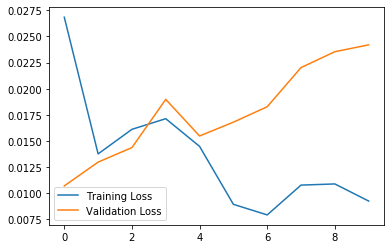

In [53]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()

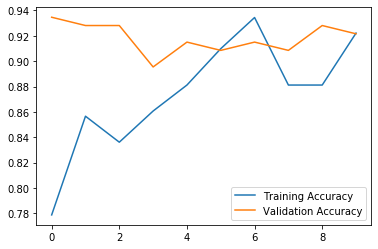

In [54]:
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(validation_acc_history, label="Validation Accuracy")
plt.legend()

## Testing

### Get a Test Image

In [0]:
from PIL import Image, ImageOps
import requests

test_ant_url = "https://i.kinja-img.com/gawker-media/image/upload/c_fill,f_auto,fl_progressive,g_center,h_675,pg_1,q_80,w_1200/tk07remacvnuvxmyhllq.jpg"
test_bee_url = "https://sureguardpest.com/wp-content/uploads/2019/06/bee-146810332.jpg"

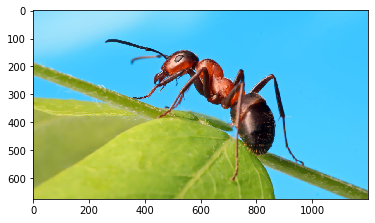

In [56]:
resp = requests.get(test_ant_url, stream=True)
img_ant = Image.open(resp.raw)
plt.imshow(img_ant)

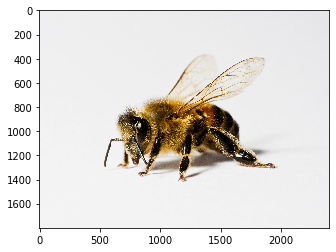

In [57]:
resp = requests.get(test_bee_url, stream=True)
img_bee = Image.open(resp.raw)
plt.imshow(img_bee)

### Do image preprocessing

The test image must match the image format on which our model was trained on.  
* 224x224
* RGB color images

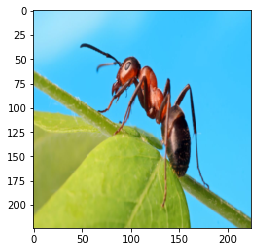

In [58]:
img_ant_trans = transform_validation(img_ant)
plt.imshow(img_convert(img_ant_trans))

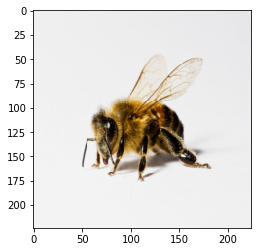

In [59]:
img_bee_trans = transform_validation(img_bee)
plt.imshow(img_convert(img_bee_trans))

### Feed to Model

In [60]:
image_ant_in = img_ant_trans.to(device).unsqueeze(0)
print(image_ant_in.size())

torch.Size([1, 3, 224, 224])


In [61]:
image_bee_in = img_bee_trans.to(device).unsqueeze(0)
print(image_bee_in.size())

torch.Size([1, 3, 224, 224])


In [62]:
output = model.forward(image_ant_in)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


In [63]:
output = model.forward(image_bee_in)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


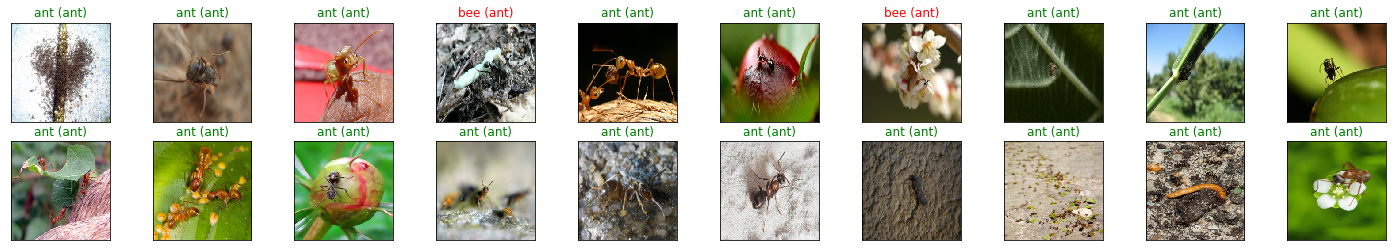

In [64]:
testdata_iter = iter(validation_loader)
images, labels = testdata_iter.next()
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title(
      "{} ({})".format(
        str(classes[preds[idx].item()]), 
        str(classes[labels[idx].item()])), 
      color=("green" if preds[idx]==labels[idx] else "red"))